# 1、torch.nn.parameter
torch.nn.parameter 是 PyTorch 中的一种特殊类型的 tensor，用于表示神经网络中的可学习参数。在 PyTorch 中，可学习参数是模型在训练过程中需要更新的变量，例如 全连接层 torch.nn.Linear() 中的参数 weight 和 bias 。

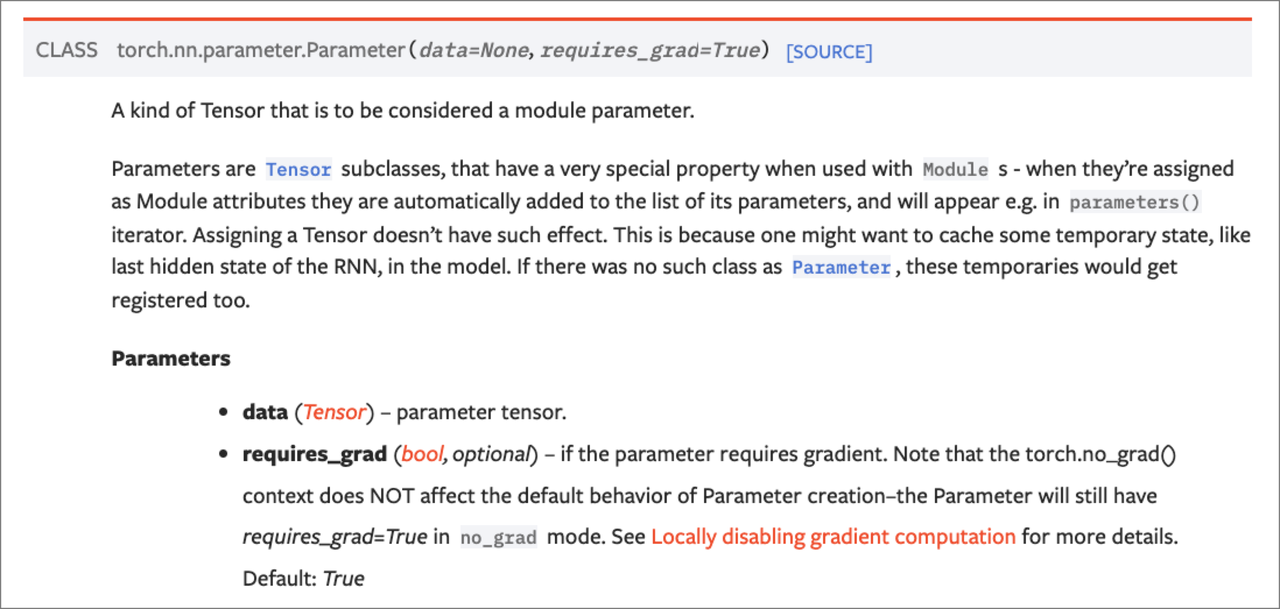

torch.nn.Parameter 是继承自 torch.Tensor 的子类，其主要作用是作为 nn.Module 中的可训练参数使用。

# 2、torch.nn.Parameter 与 torch.Tensor 的区别
## 1）自动添加到模型参数列表中
使用 torch.nn.Parameter 定义的张量会被自动添加到模型的参数列表中，并且可以通过 .parameters() 方法 或 .named_parameters() 方法列出。

In [ ]:
import torch
import torch.nn as nn


class Layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.tensor([1., 2.]))

    def forward(self, input):
        return input * self.weight

layer = Layer()
print(layer.weight.requires_grad)  # True

for name, param in layer.named_parameters():
    print(name)  # weight
    print(param)   # Parameter containing: tensor([1., 2.], requires_grad=True)

普通的 torch.Tensor 对象不会被自动添加到模型的参数列表中，因此不会被 .parameters() 方法 或 .named_parameters() 方法列出。

In [ ]:
import torch
import torch.nn as nn

class Layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = torch.Tensor([1., 2.])

    def forward(self, input):
        return input * self.weight

layer = Layer()
print(layer.weight.requires_grad)  # False

for name, param in layer.named_parameters():
    print(name, param)   # 无输出

## 2）requires_grad 属性
torch.nn.Parameter 对象的 requires_grad 属性默认为 True，因此它们被视为模型的可训练参数，并在反向传播中进行梯度计算和优化器更新

In [ ]:
import torch

a = torch.nn.Parameter(torch.tensor([1., 2., 3.]))
print(a.requires_grad)  # True

普通的 torch.Tensor 对象的 requires_grad 属性默认为 False，可手动设置为等于 True

In [ ]:
import torch

a = torch.Tensor([1., 2., 3.])
print(a.requires_grad)  # False

a.requires_grad = True
print(a.requires_grad)  # True

## 3）自动求导和优化器更新
当 torch.nn.Parameter 对象的 requires_grad 属性为 True 时，它们会参与自动求导，并且可以被优化器自动更新。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.tensor([1., 2.]))

    def forward(self, input):
        return input * self.weight


# 定义网络
model = Model()

# 查看更新前的权重
print(model.weight)   # Parameter containing: tensor([1., 2.], requires_grad=True)


# 前向传播
output = model(2)

# 定义损失函数，并计算损失
criterion = nn.CrossEntropyLoss()
loss = criterion(output, torch.tensor([3., 6.]))

# 定义优化器并反向传播
optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
loss.backward()
optimizer.step()

# 查看更新后的权重（查看参数是否更新）
print(model.weight)   # Parameter containing: tensor([1.0385, 1.9615], requires_grad=True)

对于普通的 torch.Tensor 对象，即使将其 requires_grad 属性设置为 True，它们也不会被自动添加到模型参数中，也不会被优化器自动更新。

# 3、举例说明
以 torch.nn.Linear 为例，观察在 nn.Module 类中，是如何使用 nn.Parameter 来对参数进行初始化的

删减版 （简版）

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Linear(nn.Module):

    def __init__(self, in_features: int, out_features: int):

        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.empty((out_features, in_features)))
        self.bias = torch.nn.Parameter(torch.empty(out_features))

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)


layer = Linear(3, 5)
output = layer(torch.rand(1, 3))
print(output.shape)   # torch.Size([1, 5])

实际版本

In [ ]:
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

从上面代码可以看到， Linear 在初始化时，weights 和 bias 都是使用 torch.nn.Parameter() 来生成的，也就是下面这两行代码：

In [ ]:
self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
self.bias = torch.nn.Parameter(torch.Tensor(out_features))